# Russian Authors on the Internet<a id='top'></a>

This page allows you to browse through the topic model I created based on a corpus of 37 blogs and profiles in social media, written by 31 different Russian authors. For more details, see chapter 2 of my thesis. The scripts and data used here are the sames I used to create the plots in my thesis.

Scroll down to see the plots or use these links:

* [Estimate number of clusters](#clusters)
* [Corpus map](#map)
* [Topic intensity](#topic_bubbles)
* [Print topics](#print_topics)
* [Development of topics over time](#stats_per_topic)
* [Topic statistics per blog or profile](#stats_per_blog)
* [Data table for corpus / subcorpus / blog or profile](#data)

In [107]:
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from sklearn.manifold import Isomap
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import qgrid
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output, display
import ipywidgets as widgets
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist, squareform
import scripts.spin as sp
from sklearn.metrics import silhouette_score
from gensim import corpora, models
import os
from operator import itemgetter
import datetime as dt

figsize(15, 10)

result_path = "results"
file_name = "topics"

number = 0
for f in os.listdir(result_path):
    try:
        number = max(number, int(f.split(file_name+"-")[1].split(".json")[0]))
    except IndexError:
        continue
if number > 0:
    file_name = file_name + "-" + str(number)+".json"
else:
    file_name = file_name + ".json"
print("Loading", file_name)
    
table = pd.read_json(os.path.join(result_path, file_name), orient='split')

def percent(x, pos):
    return str(int(x * 100)) + "%"

formatter = FuncFormatter(percent)

def corpus_stats(Subcorpus):
    sub = table.loc[table['group'].str.contains(Subcorpus)]
    # get top topics
    weighted = sub['words'] / sub['words'].sum()
    sub2 = sub.copy()
    sub2[sub2.columns[5:]] = sub2[sub2.columns[5:]].multiply(weighted, axis='index')
    top_topics = sub2[sub2.columns[4:]].sum()
    new_index = ['url', 'date']
    for idx in top_topics.index:
        new_index.append(idx)
    sub = sub[new_index]
    return sub, top_topics
    
def topic_stats(Topics):
    topic_stats = table.copy()
    topic_stats['date'] = pd.to_datetime(topic_stats['date'], errors="coerce", utc=True)
    topic_stats.index = pd.DatetimeIndex(topic_stats.date)
    weighted = topic_stats['words'] / topic_stats['words'].sum()
    topic_stats[topic_stats.columns[5:]] = topic_stats[topic_stats.columns[5:]].multiply(weighted, axis='index')
    
    # reduce to topics
    for Topic in Topics:
        topic_stats[(topic_stats.index.year>2004)][Topic].resample('M',how='sum').plot(kind='line', label=Topic)
    plt.legend(loc='best')
    plt.show()
    
def plot(data, title="Isomap", clrs=None, max_val=0, words=None, labels=None, huep=False):
    if clrs is None:
        clrs = [0]*len(data)
    if labels is None:
        labels = [""]*len(data)
    if words is None:
        words = [250]*len(data)   
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    matplotlib.rcParams.update({'font.size': 12})
    plt.title(title)
    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.2, 0.2)
    ax1.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off')
    scatter = ax1.scatter(data.T[0], data.T[1], marker='o', s=words, c=clrs,
                          vmin=0, vmax=max_val, cmap=matplotlib.cm.get_cmap('coolwarm'))
    for counter in range(len(data)):
        label_scale = words[counter]/(70*2500)
        plt.annotate(labels[counter].split(":")[-1], xy=(data[counter][0]+label_scale, data[counter][1]+label_scale))
    plt.tight_layout()
    if huep:
        plt.colorbar(scatter, format=formatter)
    plt.show()

# create statistics per blog
names = table['group'].drop_duplicates()
series = []
for name in names:
    sub, top_topics = corpus_stats(name)
    series.append(top_topics)
stats_per_blog = pd.concat(series, axis=1).transpose()
stats_per_blog.index = names

names = ['', 'everyday', 'literary', 'political']
names.extend(pd.DataFrame({'count': table.groupby(["group"]).size()}).reset_index()['group'])

# prepare matrix for isomap / distance matrix
topics_per_blog = stats_per_blog.copy()
del topics_per_blog['words']
matrix = topics_per_blog.as_matrix()

Loading topics.json


## Estimate number of clusters<a id='clusters'></a>

Create an elbow plot to estimate a sane number of clusters for the corpus.

[Back to top](#top)

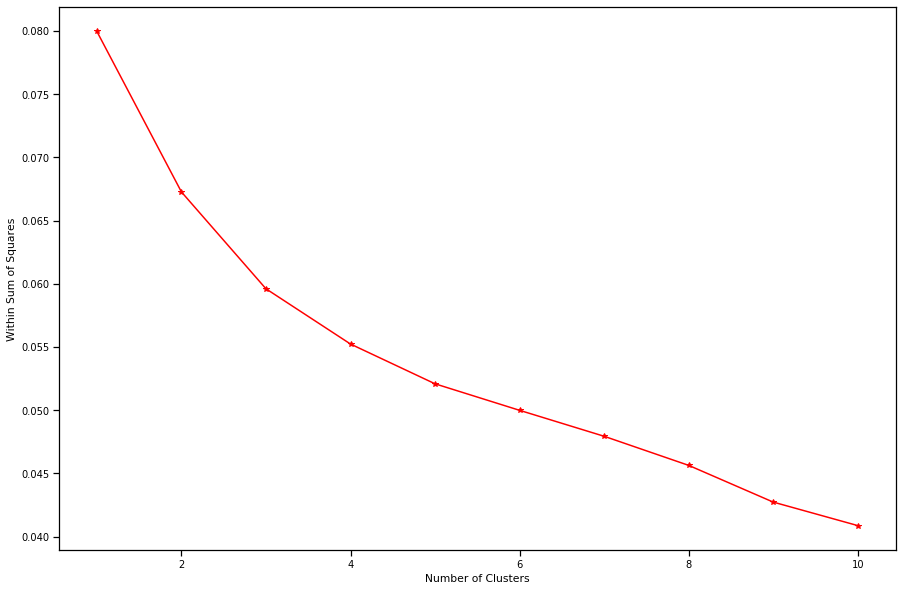

In [108]:
K = range(1,11)
KM = [KMeans(n_clusters=k).fit(matrix) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(matrix, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/matrix.shape[0] for d in dist]

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel(u'Within Sum of Squares')
plt.show()


## Corpus overview using Isomap<a id='map'></a>

In this plot the 37 blogs and social media profiles are represented by their topic distribution. The Isomap algorithm is used to create a two-dimensional map of this high-dimensional topic space. Each dot represents a blog/profile; dots close to each other have a similar topic distribution. Colors indicate groups suggested by K-means clustering.

[Back to top](#top)

In [109]:
def plot_corpus(Clusters=4):
    # cluster blogs
    km = KMeans(n_clusters=Clusters, random_state=5)
    clusters = km.fit_predict(matrix)
    print("Silhouette score:", silhouette_score(matrix, clusters))

    # plot corpus map using Isomap
    imap = Isomap()
    corpus_map = imap.fit_transform(matrix)
    figsize (13, 10)
    plot(corpus_map, "Corpus Map", labels=table['group'].drop_duplicates().values, clrs=clusters, max_val=Clusters)
    figsize (15, 10)

interact(plot_corpus, Clusters=range(2,10), );

interactive(children=(Dropdown(description='Clusters', index=2, options=(2, 3, 4, 5, 6, 7, 8, 9), value=4), Ou…

## Plot distance matrix

Create a distance matrix showing distances between different blogs or social media profiles.

[Back to top](#top)

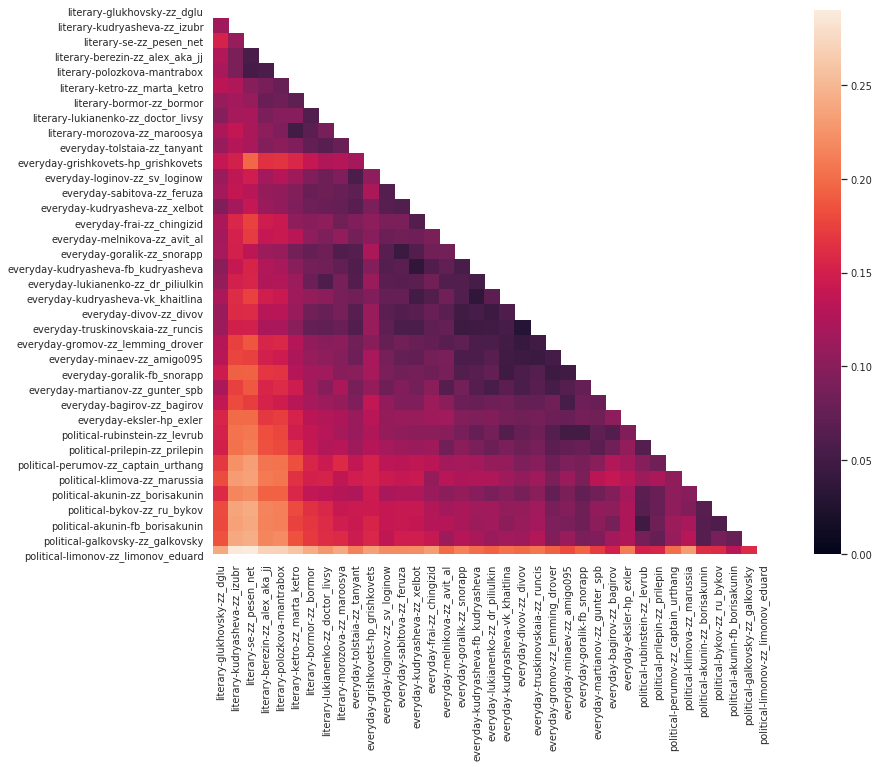

In [110]:
distances = pdist(topics_per_blog.values, metric='euclidean')
dist_matrix = squareform(distances)

#sort blogs with SPIN
order = np.array(range(len(dist_matrix[0])))
new_distances, new_order = sp.spin(dist_matrix, order)

# re-sort ids according to spin
new_ids = []
for index in new_order:
    new_ids.append(stats_per_blog.index[index].split(":")[-1])

dist_matrix = pd.DataFrame(new_distances)
dist_matrix.columns = new_ids
dist_matrix.index = new_ids

mask = np.zeros_like(new_distances)
mask[np.triu_indices_from(mask)] = True
seaborn.set_context("notebook", font_scale=0.9)
with seaborn.axes_style("white"):
    ax = seaborn.heatmap(dist_matrix, mask=mask, square=True, annot=False, fmt='.2f')
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()
figsize (15, 10)

## Plot topic bubbles<a id='topic_bubbles'></a>

Again, the Isomap algorithm is used to create a map of the corpus. Use the dropdown box to select a topic; colors indicate intensity of topic, bubble size is total number of words in a blog/profile.

[Back to top](#top)

In [111]:
words = stats_per_blog['words']
copy = stats_per_blog.copy()
del copy['words']
matrix = copy.as_matrix()

# scale dots with blog size
max_words = max(words)
num = 0
while(num < len(words)):
    words[num] = 2500*words[num]/max_words
    num += 1
    
def create_bubbles(Topic=41):
    # Isomap
    imap = Isomap()
    X = imap.fit_transform(matrix)
    plot(X, list(copy)[Topic], matrix[:, Topic], max(matrix[:, Topic]), words, huep=True)
    
box = {}
counter = 0
for label in list(table)[5:]:
    box[label] = counter
    counter += 1
box = sorted(box.items(), key=lambda x: x[1])
    
interact(create_bubbles, Topic=box);

interactive(children=(Dropdown(description='Topic', index=41, options=(('Städtenamen?', 0), ('1', 1), ('2', 2)…

## Print topics<a id='print_topics'></a>

Print the ten most typicals words for each topic.

[Back to top](#top)

In [112]:
result_path = "results"
model_name = "model"

number = 0
for f in os.listdir(result_path):
    try:
        number = max(number, int(f.split(model_name+"-")[1].split(".lda")[0]))
    except IndexError:
        continue
    except ValueError:
        continue
if number > 0:
    file_name = model_name + "-" + str(number) + ".lda"
else: 
    file_name = model_name + ".lda"

# load LDA model and dictionary
dictionary = corpora.Dictionary.load(os.path.join(result_path, model_name + ".dict"))
model = models.LdaModel.load(os.path.join(result_path, file_name))
    
topics = model.show_topics(num_topics=50, num_words=10, log=False, formatted=True)
counter = 5
for topic in sorted(topics, key=itemgetter(0)):
    print (list(table)[counter], ":\n", topic[1], "\n")
    counter += 1

Städtenamen? :
 0.147*"картинка" + 0.096*"метка" + 0.028*"вильнюс" + 0.021*"удальцов" + 0.021*"испания" + 0.012*"комиссар" + 0.010*"консервы" + 0.008*"травля" + 0.008*"ритуал" + 0.007*"сталинизм" 

1 :
 0.120*"игра" + 0.033*"дядя" + 0.029*"кадр" + 0.021*"слон" + 0.019*"команда" + 0.016*"вася" + 0.012*"запрос" + 0.010*"тётенька" + 0.009*"петя" + 0.009*"трактор" 

2 :
 0.018*"общественность" + 0.014*"бомба" + 0.012*"критика" + 0.011*"тупик" + 0.011*"злоба" + 0.011*"татарин" + 0.010*"пелевин" + 0.010*"пиар" + 0.009*"анна" + 0.009*"гельман" 

Natur :
 0.030*"окно" + 0.018*"вода" + 0.016*"яндексфотка" + 0.014*"дорога" + 0.013*"земля" + 0.011*"солнце" + 0.010*"дом" + 0.010*"снег" + 0.009*"небо" + 0.009*"берег" 

Artem? :
 0.078*"артём" + 0.061*"сенька" + 0.030*"волк" + 0.020*"тигр" + 0.014*"минаев" + 0.014*"ир" + 0.013*"чуковский" + 0.011*"садик" + 0.011*"щит" + 0.011*"лев" 

Fantasy I :
 0.029*"остров" + 0.020*"император" + 0.014*"собор" + 0.014*"племя" + 0.013*"олимпиада" + 0.011*"вождь" +

***
## Topic development over time
<a id='stats_per_topic'></a>

Select topics to view their development over time for the whole corpus. You may select multiple topics with the CTRL key.

[Back to top](#top)


In [113]:
selected = [list(table)[45], list(table)[42]] 
interact(topic_stats, Topics= widgets.SelectMultiple(options=list(table)[5:], value=selected));

interactive(children=(SelectMultiple(description='Topics', index=(40, 37), options=('Städtenamen?', '1', '2', …

## Top ten topics for a blog / a profile<a id='stats_per_blog'></a>

Select a blog/social media profile in the dropdown box. The naming convention is as follows: subcorpus:author:alias, e.g. everyday:goralik:zz_snorapp.

[Back to top](#top)


In [114]:
figsize(10,6)
def create_bars(Subcorpus):
    sub, top_topics = corpus_stats(Subcorpus)
    del top_topics['words']
    top_topics.sort_values(ascending=False, inplace=True)
    top_topics = top_topics.head(10)
    top_topics.plot(kind='bar')
    plt.show()

interact(create_bars, Subcorpus=names);

interactive(children=(Dropdown(description='Subcorpus', options=('', 'everyday', 'literary', 'political', 'eve…

## Show data table for corpus / subcorpus / blog or profile<a id='data'></a>
Select a blog/social media profile in the dropdown box. The naming convention is as follows: subcorpus:author:alias, e.g. everyday:goralik:zz_snorapp.

[Back to top](#top)

In [115]:
qgrid.show_grid(table, grid_options={'fullWidthRows': True, 'explicitInitialisation':True, 'asyncEditorLoading': True, 'enableTextSelectionOnCells': True, 'syncColumnCellResize':True, 'enableColumnReorder':False,'forceFitColumns': False, 'defaultColumnWidth': 80, 'enableCellNavigation': True})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…